In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.impute import SimpleImputer
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/thyroid_cancer_risk_data.csv')

# Display the first few rows and basic information about the dataset
print(df.head())
print(df.info())

   Patient_ID  Age  Gender  Country  Ethnicity Family_History  \
0           1   66    Male   Russia  Caucasian             No   
1           2   29    Male  Germany   Hispanic             No   
2           3   86    Male  Nigeria  Caucasian             No   
3           4   75  Female    India      Asian             No   
4           5   35  Female  Germany    African            Yes   

  Radiation_Exposure Iodine_Deficiency Smoking Obesity Diabetes  TSH_Level  \
0                Yes                No      No      No       No       9.37   
1                Yes                No      No      No       No       1.83   
2                 No                No      No      No       No       6.26   
3                 No                No      No      No       No       4.10   
4                Yes                No      No      No       No       9.10   

   T3_Level  T4_Level  Nodule_Size Thyroid_Cancer_Risk Diagnosis  
0      1.67      6.16         1.08                 Low    Benign  
1     

In [ ]:
# Descriptive statistics
print(df.describe())

         Patient_ID            Age      TSH_Level       T3_Level  \
count  212691.00000  212691.000000  212691.000000  212691.000000   
mean   106346.00000      51.918497       5.045102       2.001727   
std     61398.74739      21.632815       2.860264       0.866248   
min         1.00000      15.000000       0.100000       0.500000   
25%     53173.50000      33.000000       2.570000       1.250000   
50%    106346.00000      52.000000       5.040000       2.000000   
75%    159518.50000      71.000000       7.520000       2.750000   
max    212691.00000      89.000000      10.000000       3.500000   

            T4_Level    Nodule_Size  
count  212691.000000  212691.000000  
mean        8.246204       2.503403  
std         2.164188       1.444631  
min         4.500000       0.000000  
25%         6.370000       1.250000  
50%         8.240000       2.510000  
75%        10.120000       3.760000  
max        12.000000       5.000000  


This code loads the dataset and provides an initial overview of its structure and content.*italicized text*




# **Exploratory Data Analysis (EDA) & Visualization**


Let's perform some exploratory data analysis to gain insights into the dataset:

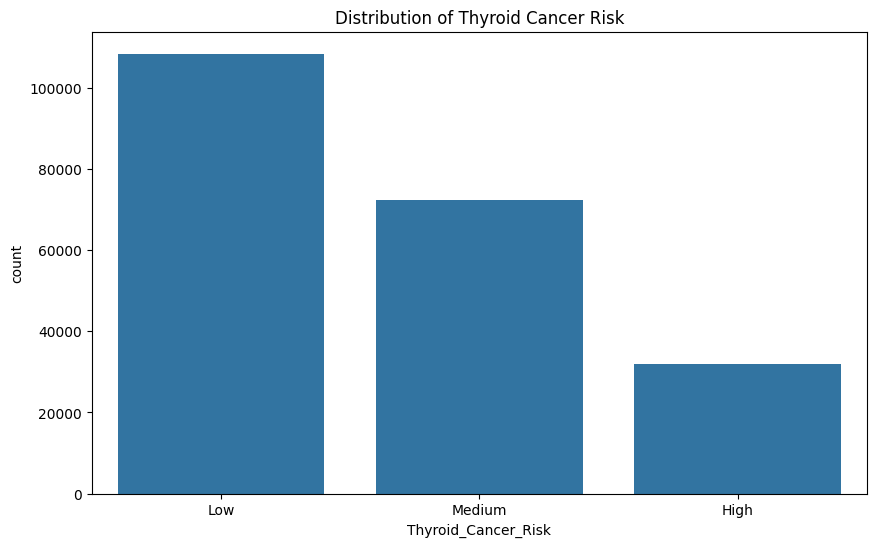

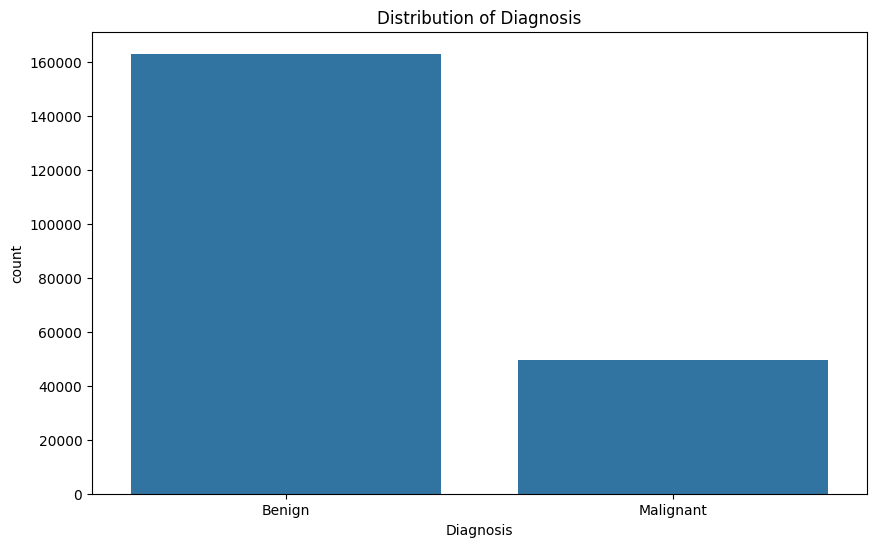

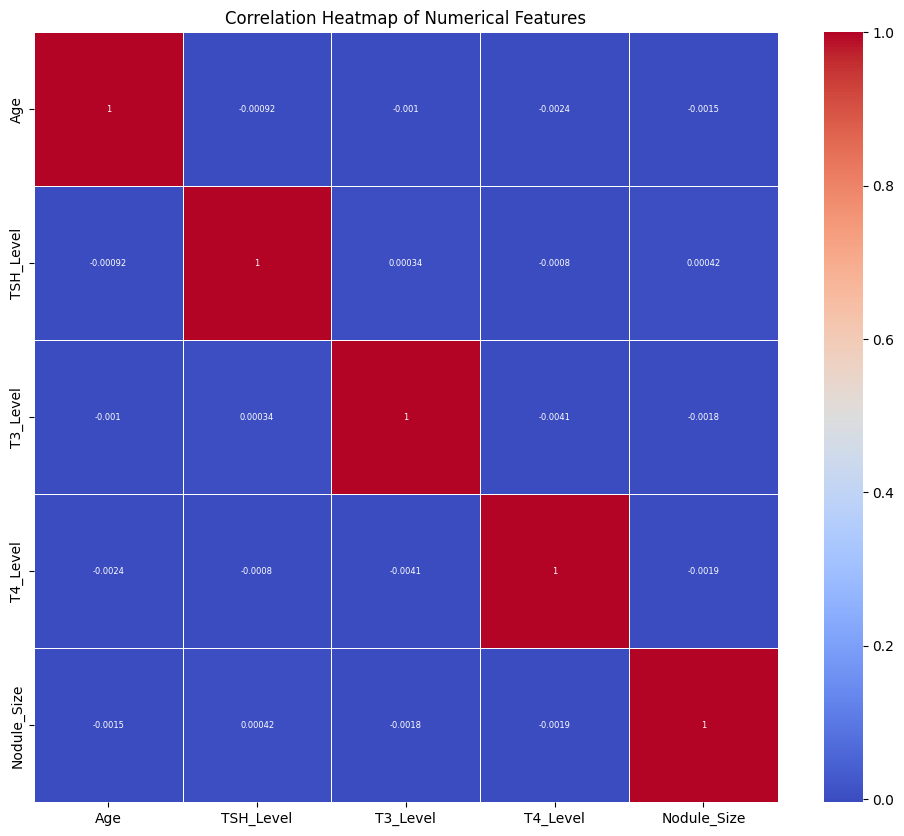

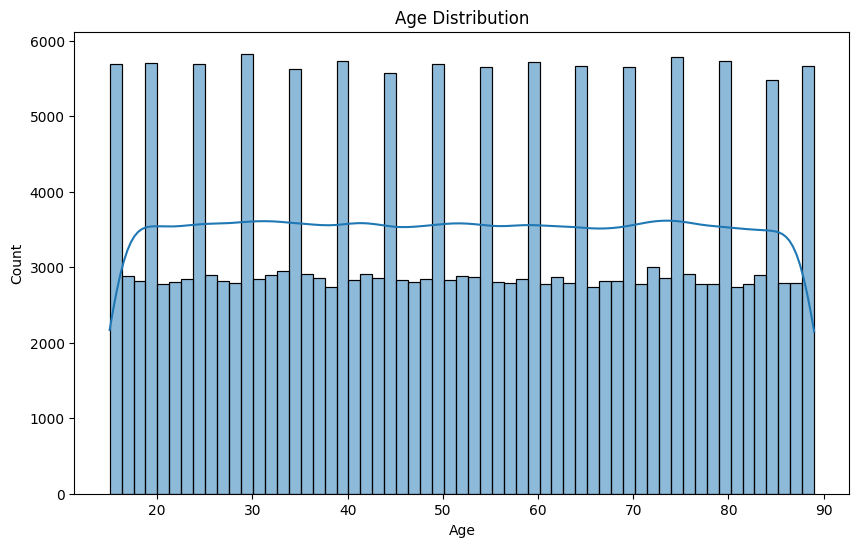

In [ ]:
# Distribution of Thyroid Cancer Risk
plt.figure(figsize=(10, 6))
sns.countplot(x='Thyroid_Cancer_Risk', data=df)
plt.title('Distribution of Thyroid Cancer Risk')
plt.show()

# Distribution of diagnosis
plt.figure(figsize=(10, 6))
sns.countplot(x='Diagnosis', data=df)
plt.title('Distribution of Diagnosis')
plt.show()

# Correlation heatmap for numerical features
numerical_features = ['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']

plt.figure(figsize=(12, 10))
sns.heatmap(df[numerical_features].corr(), annot=True, cmap='coolwarm', linewidths=0.4, annot_kws={"size":6})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

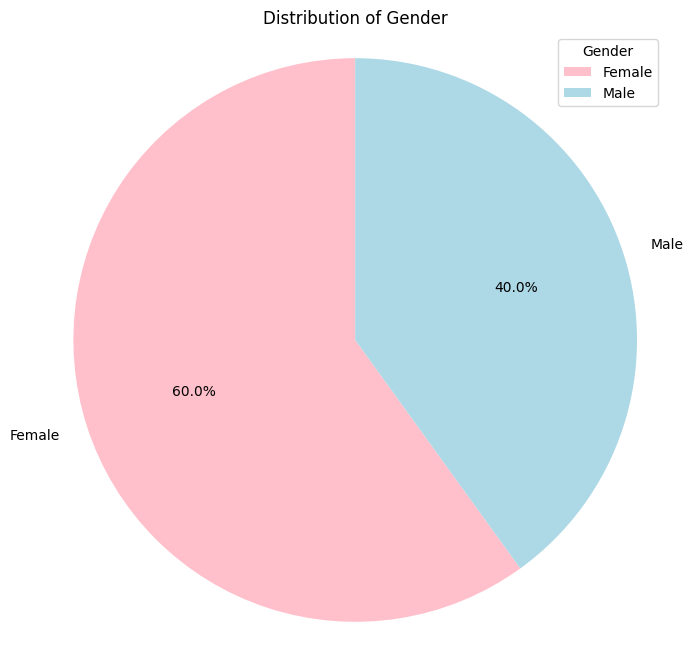

In [ ]:
# Gender distribution
gender_counts = df['Gender'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=['pink','lightblue'])
plt.title('Distribution of Gender')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.legend(title="Gender")
plt.show()

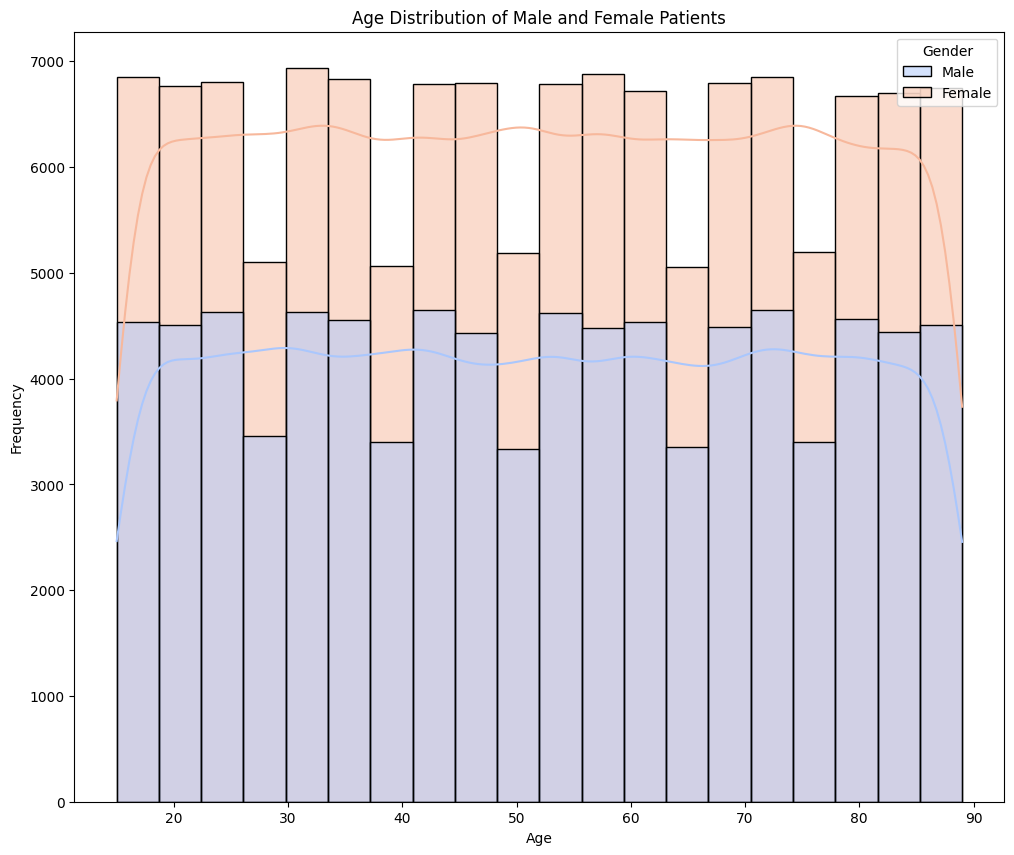

In [ ]:
# Age distribution based on Gender
plt.figure(figsize=(12, 10))
sns.histplot(df, x="Age", hue="Gender", bins=20, kde=True, palette="coolwarm")
plt.title("Age Distribution of Male and Female Patients")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

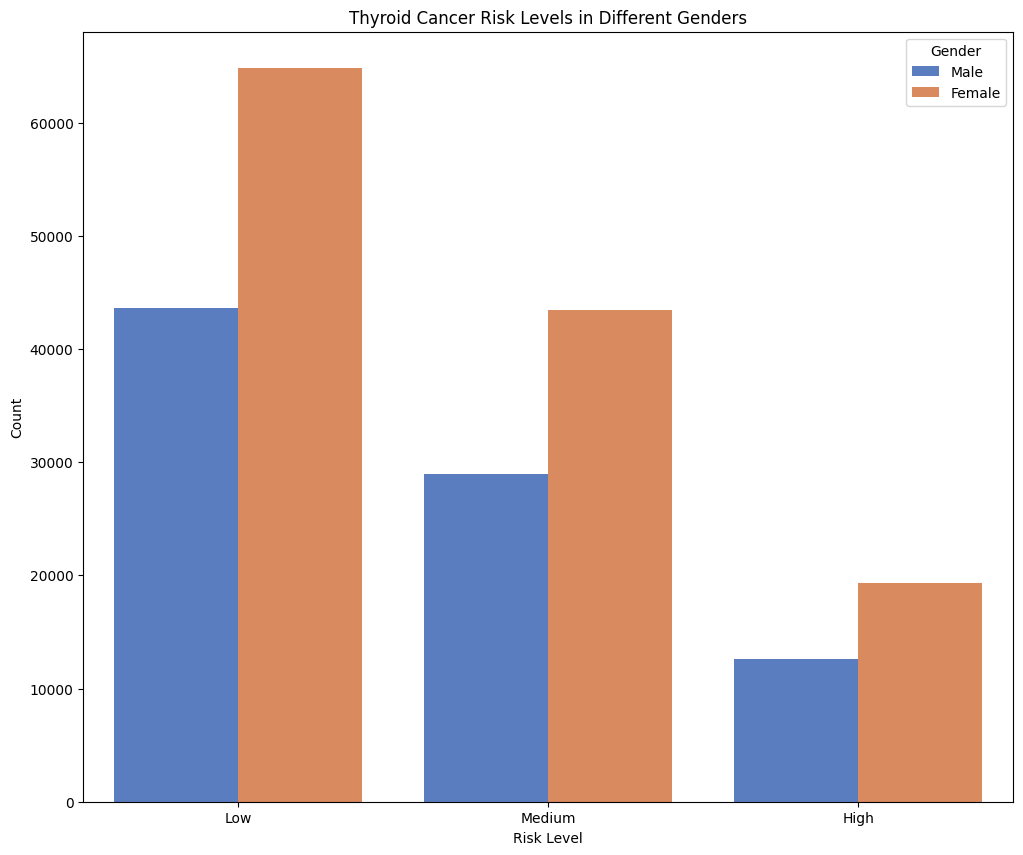

In [ ]:
# Thyroid Cancer Risk Level based on Gender
plt.figure(figsize=(12, 10))
sns.countplot(data=df, x="Thyroid_Cancer_Risk", hue="Gender", palette="muted")
plt.title("Thyroid Cancer Risk Levels in Different Genders")
plt.xlabel("Risk Level")
plt.ylabel("Count")
plt.show()

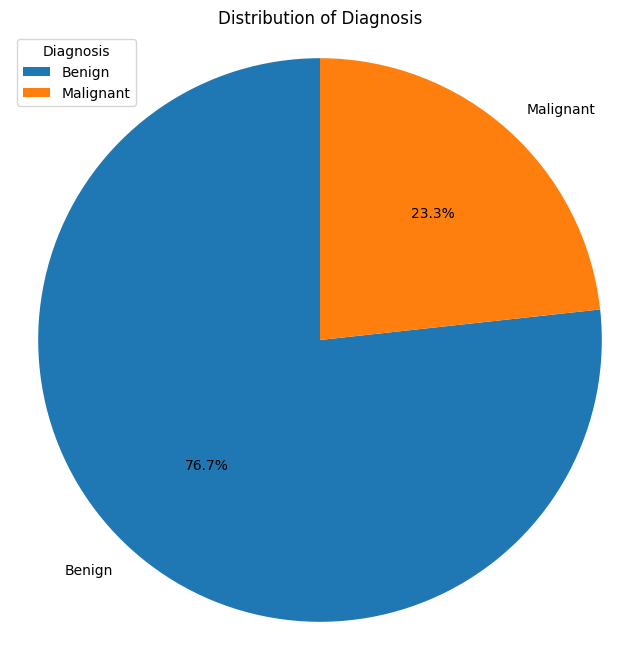

In [ ]:
# Diagnosis distribution
diagnosis_counts = df['Diagnosis'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(diagnosis_counts.values, labels=diagnosis_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Diagnosis')
plt.axis('equal')
plt.legend(title="Diagnosis")
plt.show()

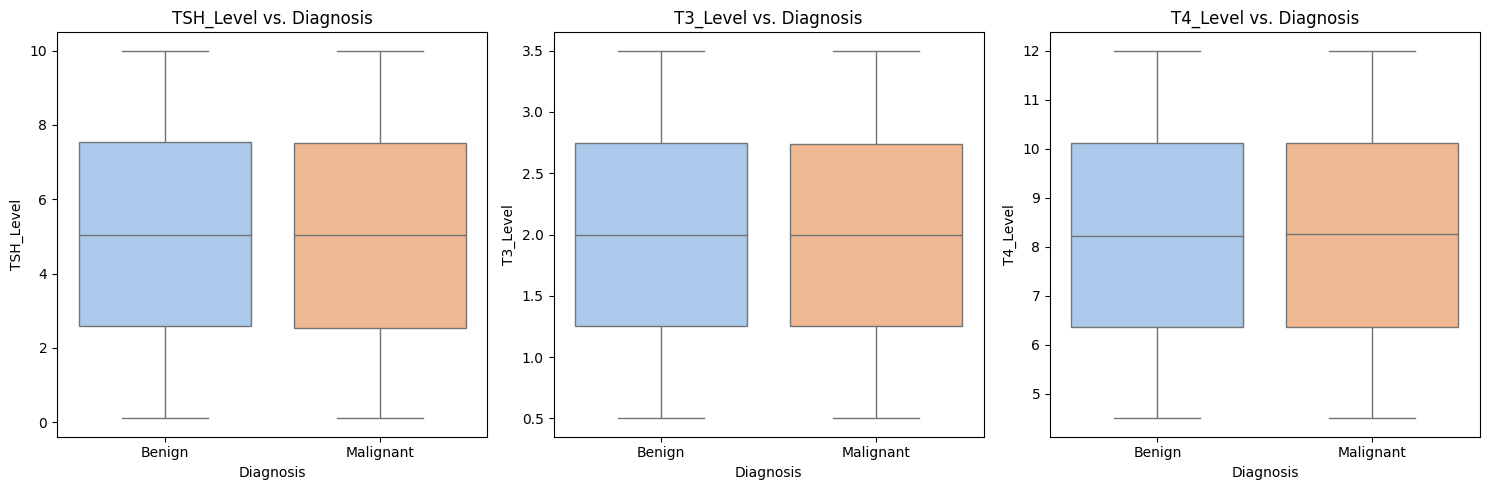

In [ ]:
# Box plots for TSH, T3, and T4 levels vs. Diagnosis
hormone_levels = ['TSH_Level', 'T3_Level', 'T4_Level']
plt.figure(figsize=(15, 5))
for i, hormone in enumerate(hormone_levels):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df, x='Diagnosis', y=hormone, palette="pastel")
    plt.title(f'{hormone} vs. Diagnosis')
plt.tight_layout()
plt.show()

These visualizations help understand the distribution of key variables and their relationships.



# **Data Preprocessing**


Now, let's preprocess the data by handling missing values, encoding categorical variables, and scaling numerical features:

In [ ]:
# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Encode categorical variables
mapping_dict = {
    "Family_History": {"Yes": 1, "No": 0},
    "Radiation_Exposure": {"Yes": 1, "No": 0},
    "Iodine_Deficiency": {"Yes": 1, "No": 0},
    "Smoking": {"Yes": 1, "No": 0},
    "Obesity": {"Yes": 1, "No": 0},
    "Diabetes": {"Yes": 1, "No": 0},
    "Thyroid_Cancer_Risk": {"Low": 0, "Medium": 1, "High": 2},
    "Diagnosis": {"Benign": 0, "Malignant": 1}
}
for column, mapping in mapping_dict.items():
    if column in df.columns:
        df[column] = df[column].map(mapping)

# Scale numerical features
scaler = StandardScaler()
numerical_cols = ['Age', 'TSH_Level', 'T3_Level', 'T4_Level', 'Nodule_Size']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Drop irrelevant columns
df = df.drop(columns=["Patient_ID", "Country", "Ethnicity", "Gender"], errors='ignore')

print(df.head())

        Age  Family_History  Radiation_Exposure  Iodine_Deficiency  Smoking  \
0  0.650934               0                   1                  0        0   
1 -1.059435               0                   1                  0        0   
2  1.575458               0                   0                  0        0   
3  1.066970               0                   0                  0        0   
4 -0.782077               1                   1                  0        0   

   Obesity  Diabetes  TSH_Level  T3_Level  T4_Level  Nodule_Size  \
0        0         0   1.512066 -0.382947 -0.963968    -0.985308   
1        0         0  -1.124060 -0.313683  1.059890     1.070585   
2        0         0   0.424751  0.679107  1.073752     1.458229   
3        0         0  -0.330426  0.713739  1.290924    -0.030045   
4        0         0   1.417669  0.124991  1.138441    -0.272322   

   Thyroid_Cancer_Risk  Diagnosis  
0                    0          0  
1                    0          0  
2       

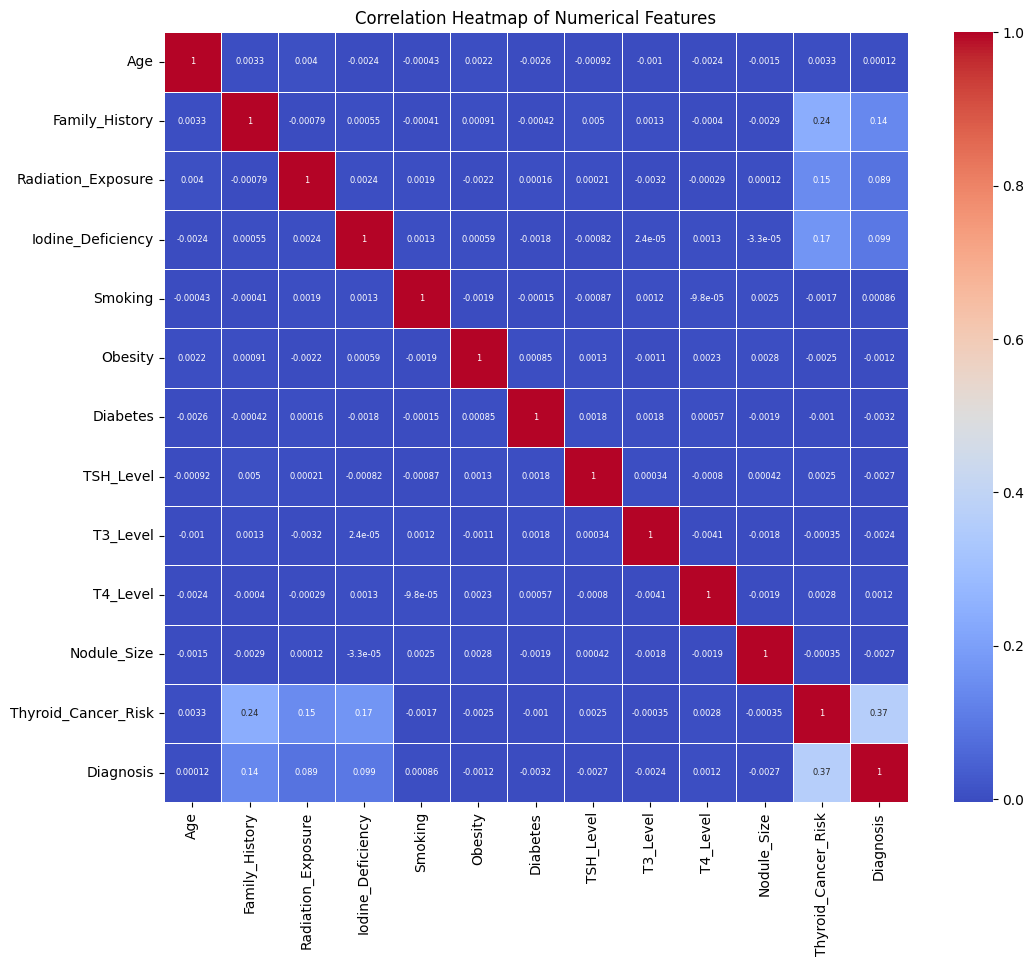

In [ ]:
# Correlation heatmap for numerical features after encoding categorical variables
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.4, annot_kws={"size":6})
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

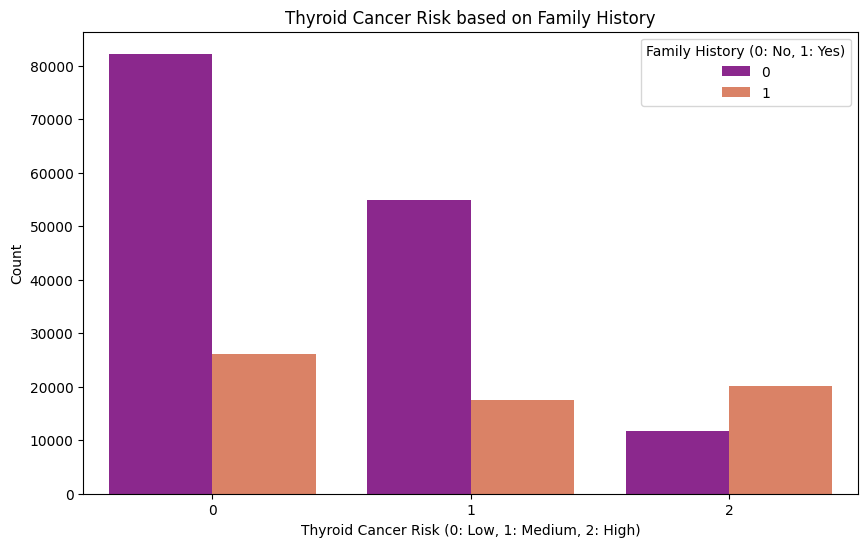

In [ ]:
# Create a count plot for Thyroid Cancer Risk based on Family History
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Thyroid_Cancer_Risk', hue='Family_History', palette='plasma')
plt.title('Thyroid Cancer Risk based on Family History')
plt.xlabel('Thyroid Cancer Risk (0: Low, 1: Medium, 2: High)')
plt.ylabel('Count')
plt.legend(title='Family History (0: No, 1: Yes)')
plt.show()

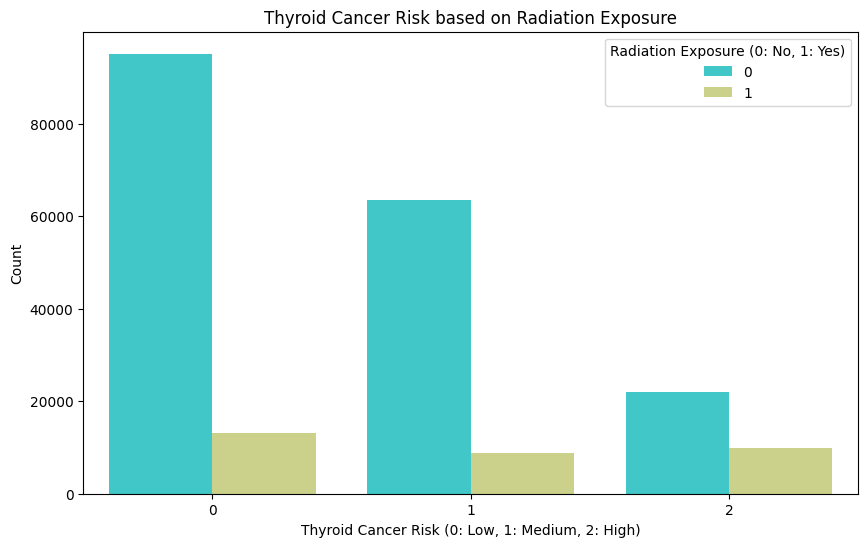

In [ ]:
# Create a count plot for Thyroid Cancer Risk based on Radiation Exposure
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Thyroid_Cancer_Risk', hue='Radiation_Exposure', palette='rainbow')
plt.title('Thyroid Cancer Risk based on Radiation Exposure')
plt.xlabel('Thyroid Cancer Risk (0: Low, 1: Medium, 2: High)')
plt.ylabel('Count')
plt.legend(title='Radiation Exposure (0: No, 1: Yes)')
plt.show()

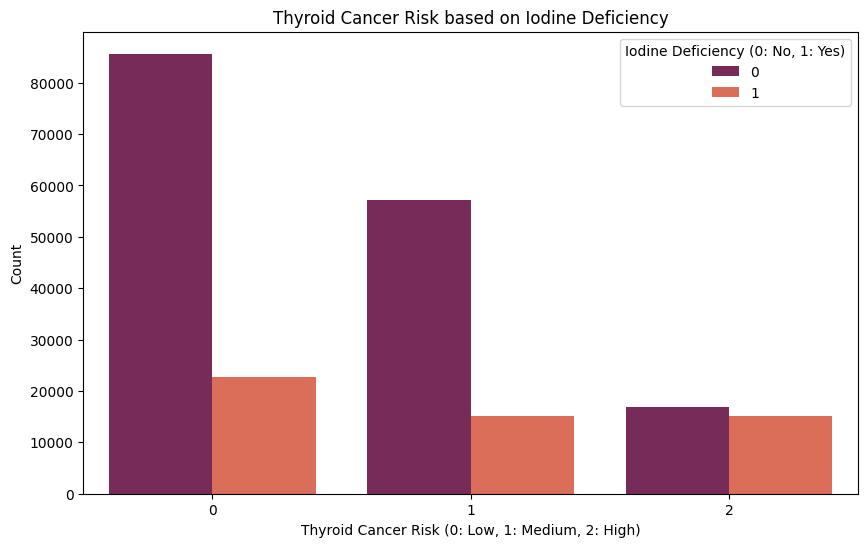

In [ ]:
# Create a count plot for Thyroid Cancer Risk based on Iodine Deficiency
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Thyroid_Cancer_Risk', hue='Iodine_Deficiency', palette='rocket')
plt.title('Thyroid Cancer Risk based on Iodine Deficiency')
plt.xlabel('Thyroid Cancer Risk (0: Low, 1: Medium, 2: High)')
plt.ylabel('Count')
plt.legend(title='Iodine Deficiency (0: No, 1: Yes)')
plt.show()

In [ ]:
# Separate features and target
X = df.drop(['Diagnosis'], axis=1)
y = df['Diagnosis']

In [ ]:
# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize features
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

*This preprocessing pipeline handles both numerical and categorical features, including scaling and encoding.*




Machine Learning: Train Models for Risk Prediction

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results.append((name, accuracy))
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))


Logistic Regression Results:
Accuracy: 0.8251
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.45      0.54      9924

    accuracy                           0.83     42539
   macro avg       0.77      0.69      0.72     42539
weighted avg       0.81      0.83      0.81     42539


Random Forest Results:
Accuracy: 0.8237
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.44      0.54      9924

    accuracy                           0.82     42539
   macro avg       0.77      0.69      0.71     42539
weighted avg       0.81      0.82      0.81     42539


Gradient Boosting Results:
Accuracy: 0.8250
              precision    recall  f1-score   support

           0       0.85      0.94      0.89     32615
           1       0.69      0.45      0.54      9924

    accuracy                           0.83     4

This code defines the models, splits the preprocessed data into training and test sets, then trains and evaluates each model. The results include accuracy and a classification report for each model.*italicized text*

Make a data frame from the results of the Models

In [ ]:
res_df = pd.DataFrame(results, columns=["Model", "Accuracy"])

In [ ]:
# Sort results by accuracy
res_df = res_df.sort_values(by=["Accuracy"], ascending=[True])

In [ ]:
# Display the sorted results
res_df

,Model,Accuracy
4,Decision Tree,0.702414
5,Naive Bayes,0.812031
1,Random Forest,0.823715
6,XGBoost,0.824114
2,Gradient Boosting,0.825008
0,Logistic Regression,0.825055
3,AdaBoost,0.825055
7,LightGBM,0.825055


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Accuracy'].plot(kind='hist', bins=20, title='Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Accuracy']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Accuracy']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Accuracy'}, axis=1)
              .sort_values('Accuracy', ascending=True))
  xs = counted['Accuracy']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Accuracy', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Accuracy')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='Accuracy', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Graph of Models performance

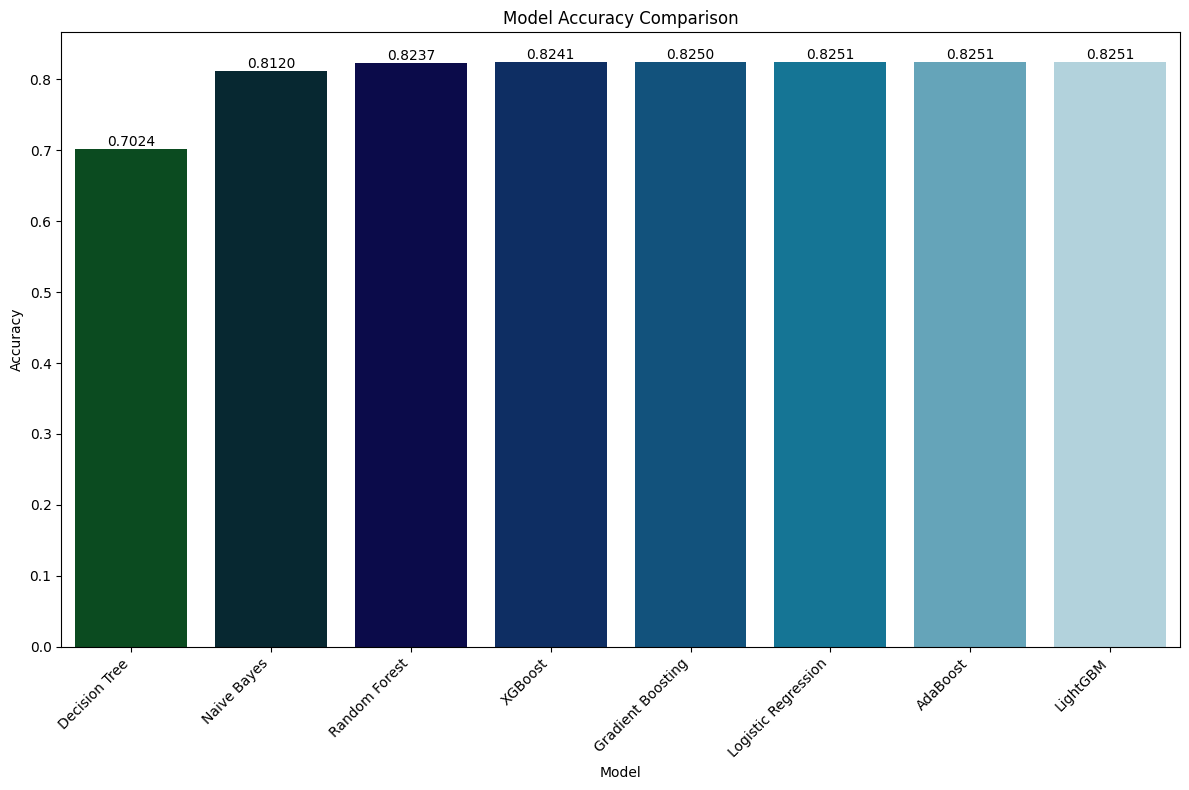

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=res_df, x="Model", y="Accuracy", palette="ocean")
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Accuracy")

# Add accuracy values on top of each bar
for i, v in enumerate(res_df['Accuracy']):
    ax.text(i, v, f'{v:.4f}', ha='center', va='bottom')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

plt.show()

Statistical Testing: Check Correlations Between Lifestyle Factors and Thyroid *Cancer*

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
lifestyle_factors = ['Smoking', 'Obesity', 'Diabetes']

for factor in lifestyle_factors:
    contingency_table = pd.crosstab(df[factor], df['Diagnosis'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-square test for {factor}:")
    print(f"p-value: {p_value}")
    print("Significant" if p_value < 0.05 else "Not significant")
    print()

Chi-square test for Smoking:
p-value: 0.6958313253476616
Not significant

Chi-square test for Obesity:
p-value: 0.5732949946709196
Not significant

Chi-square test for Diabetes:
p-value: 0.13945772780815632
Not significant



This code performs statistical tests to check for significant associations between lifestyle factors and thyroid cancer diagnosis.





